In [45]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
dfm = pd.read_csv('merged.csv')

# Logistic Regression

In [6]:
# LG - With GS 

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_selection import SelectPercentile, chi2
from joblib import dump

In [8]:
mean_popularity = 50

In [9]:
y_prime = [1 if i >= mean_popularity else 0 for i in dfm["popularity"]]
y_popl = pd.concat([pd.Series(y_prime, name="popularity")], axis=1)
y = y_popl["popularity"]

In [10]:
drop_cols = ["id", "popularity", "mode", "loudness", "loudness_ar", "loudness_yr"]
X = dfm.drop(drop_cols, axis=1)

In [11]:
X = SelectPercentile(chi2, percentile=10).fit_transform(X, y)

In [12]:
# Features scaling
input_scaler = StandardScaler()
X_normalized = input_scaler.fit_transform(X)

In [13]:
# Data Split 
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y, test_size=0.20, random_state=42, stratify=y
)

In [14]:
# Setting up the parameter grid
param_grid = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['saga']
}

In [15]:
#  GridSearchCV object
grid_search = GridSearchCV(LogisticRegression(random_state=42, max_iter=10000), param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy', verbose=10)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5; 1/60] START C=0.0001, penalty=l1, solver=saga..........................
[CV 1/5; 1/60] END C=0.0001, penalty=l1, solver=saga;, score=0.863 total time=   0.2s
[CV 2/5; 1/60] START C=0.0001, penalty=l1, solver=saga..........................
[CV 2/5; 1/60] END C=0.0001, penalty=l1, solver=saga;, score=0.865 total time=   0.3s
[CV 3/5; 1/60] START C=0.0001, penalty=l1, solver=saga..........................
[CV 3/5; 1/60] END C=0.0001, penalty=l1, solver=saga;, score=0.862 total time=   0.4s
[CV 4/5; 1/60] START C=0.0001, penalty=l1, solver=saga..........................
[CV 4/5; 1/60] END C=0.0001, penalty=l1, solver=saga;, score=0.864 total time=   0.2s
[CV 5/5; 1/60] START C=0.0001, penalty=l1, solver=saga..........................
[CV 5/5; 1/60] END C=0.0001, penalty=l1, solver=saga;, score=0.864 total time=   0.4s
[CV 1/5; 2/60] START C=0.0001, penalty=l2, solver=saga..........................
[CV 1/5; 2/60] END C=0

/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
100 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/vaishnavimocherla/anaconda3/lib/python

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(max_iter=10000, random_state=42),
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['saga']},
             scoring='accuracy', verbose=10)

In [16]:
# Saving the best model

dump(grid_search.best_estimator_, "mlspotify_logreg_gs")

['mlspotify_logreg_gs']

In [17]:
# Printing the best parameters and the best score

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 0.012742749857031334, 'penalty': 'l1', 'solver': 'saga'}
Best cross-validation accuracy: 0.91


In [41]:
# Evaluating on the test set

y_pred_lr = grid_search.predict(X_test)
print("Test accuracy: {:.2f}".format(grid_search.score(X_test, y_test)))

Test accuracy: 0.92


In [42]:
# Confusion matrix and classification report

print(confusion_matrix(y_test, y_pred_lr))
print("Classification report\n")
print(classification_report(y_test, y_pred_lr))

[[27975   737]
 [ 2173  3561]]
Classification report

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     28712
           1       0.83      0.62      0.71      5734

    accuracy                           0.92     34446
   macro avg       0.88      0.80      0.83     34446
weighted avg       0.91      0.92      0.91     34446



In [40]:
from sklearn.metrics import roc_curve, auc

In [43]:
# Calculating ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_lr)
roc_auc = auc(fpr, tpr)

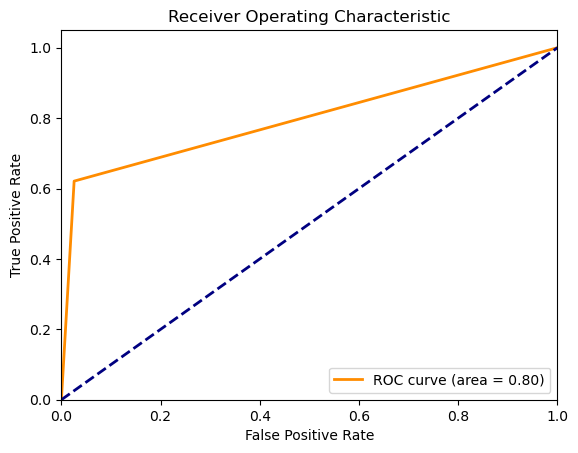

In [46]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Decision Tree

In [20]:
# DS - GS

In [21]:
from sklearn.tree import DecisionTreeClassifier

In [22]:
# Setting up parameter grid
param_grid_dt = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

In [23]:
# Creating GridSearchCV object
grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=StratifiedKFold(n_splits=5), scoring='accuracy', verbose=10)

In [24]:
# Fitting GridSearchCV
grid_search_dt.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5; 1/108] START criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2
[CV 1/5; 1/108] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.883 total time=   0.7s
[CV 2/5; 1/108] START criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2
[CV 2/5; 1/108] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.884 total time=   0.6s
[CV 3/5; 1/108] START criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2
[CV 3/5; 1/108] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.880 total time=   0.6s
[CV 4/5; 1/108] START criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2
[CV 4/5; 1/108] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.881 total time=   0.6s
[CV 5/5; 1/108] START criterion=gini, max_depth=None, min_sam

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30, 40, 50],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy', verbose=10)

In [25]:
# Saving the best model
dump(grid_search_dt.best_estimator_, "mlspotify_decision_tree_gs")

['mlspotify_decision_tree_gs']

In [26]:
# Printing the best parameters and best score
print("Best parameters:", grid_search_dt.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(grid_search.best_score_))

Best parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best cross-validation accuracy: 0.91


In [47]:
# Evaluating on the test set
y_pred_dt = grid_search_dt.predict(X_test)
print("Test accuracy: {:.2f}".format(grid_search_dt.score(X_test, y_test)))

Test accuracy: 0.92


In [48]:
# Displaying confusion matrix and classification report
print(confusion_matrix(y_test, y_pred_dt))
print("Classification report\n")
print(classification_report(y_test, y_pred_dt))

[[28119   593]
 [ 2185  3549]]
Classification report

              precision    recall  f1-score   support

           0       0.93      0.98      0.95     28712
           1       0.86      0.62      0.72      5734

    accuracy                           0.92     34446
   macro avg       0.89      0.80      0.84     34446
weighted avg       0.92      0.92      0.91     34446



In [51]:
# Calculating ROC curve and ROC area
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt)
roc_auc = auc(fpr_dt, tpr_dt)

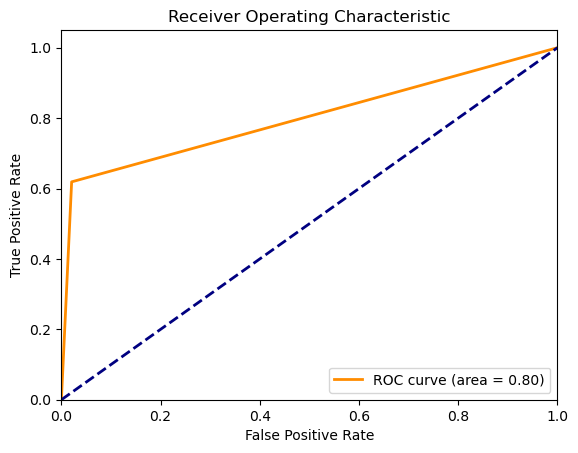

In [52]:
plt.figure()
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Ada Boost 

In [29]:
# Ada - GS 

In [32]:
from sklearn.ensemble import AdaBoostClassifier

In [33]:
# Configuring AdaBoost parameters for GridSearch
param_grid_ada = {
    'base_estimator__max_depth': [1, 2, 3],
    'base_estimator__min_samples_leaf': [1, 2, 4],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1]
}

In [34]:
# Setting up the base estimator
base_estimator = DecisionTreeClassifier(random_state=42)

# Creating GridSearchCV object
grid_search_ada = GridSearchCV(AdaBoostClassifier(base_estimator=base_estimator, random_state=42), param_grid_ada, cv=StratifiedKFold(n_splits=5), scoring='accuracy', verbose=10)


In [35]:
# Fitting GridSearchCV
grid_search_ada.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 1/5; 1/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 1/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=50;, score=0.915 total time=   3.7s
[CV 2/5; 1/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 1/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=50;, score=0.916 total time=   3.6s
[CV 3/5; 1/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 1/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=50;, score=0.915 total time=   3.3s
[CV 4/5; 1/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 1/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=50;, score=0.913 total time=   3.3s
[CV 5/5; 1/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 1/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=50;, score=0.915 total time=   3.5s
[CV 1/5; 2/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 2/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=100;, score=0.915 total time=   7.3s
[CV 2/5; 2/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 2/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=100;, score=0.916 total time=   6.8s
[CV 3/5; 2/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 2/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=100;, score=0.915 total time=   6.8s
[CV 4/5; 2/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 2/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=100;, score=0.913 total time=   6.7s
[CV 5/5; 2/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 2/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=100;, score=0.914 total time=   6.6s
[CV 1/5; 3/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 3/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=200;, score=0.913 total time=  14.4s
[CV 2/5; 3/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 3/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=200;, score=0.916 total time=  14.2s
[CV 3/5; 3/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 3/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=200;, score=0.915 total time=  13.2s
[CV 4/5; 3/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 3/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=200;, score=0.914 total time=  16.3s
[CV 5/5; 3/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 3/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=200;, score=0.914 total time=  15.0s
[CV 1/5; 4/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 4/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=50;, score=0.915 total time=   3.7s
[CV 2/5; 4/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 4/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=50;, score=0.918 total time=   3.3s
[CV 3/5; 4/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 4/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=50;, score=0.916 total time=   3.8s
[CV 4/5; 4/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 4/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=50;, score=0.914 total time=   3.3s
[CV 5/5; 4/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 4/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=50;, score=0.916 total time=   3.4s
[CV 1/5; 5/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 5/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=100;, score=0.916 total time=   7.0s
[CV 2/5; 5/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 5/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=100;, score=0.917 total time=   6.6s
[CV 3/5; 5/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 5/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=100;, score=0.916 total time=   6.7s
[CV 4/5; 5/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 5/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=100;, score=0.915 total time=   6.9s
[CV 5/5; 5/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 5/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=100;, score=0.916 total time=   6.7s
[CV 1/5; 6/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 6/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=200;, score=0.917 total time=  13.0s
[CV 2/5; 6/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 6/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=200;, score=0.918 total time=  13.0s
[CV 3/5; 6/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 6/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=200;, score=0.917 total time=  13.2s
[CV 4/5; 6/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 6/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=200;, score=0.916 total time=  13.2s
[CV 5/5; 6/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 6/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=200;, score=0.916 total time=  13.1s
[CV 1/5; 7/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 7/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=50;, score=0.917 total time=   3.5s
[CV 2/5; 7/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 7/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=50;, score=0.918 total time=   3.3s
[CV 3/5; 7/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 7/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=50;, score=0.915 total time=   3.5s
[CV 4/5; 7/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 7/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=50;, score=0.915 total time=   3.3s
[CV 5/5; 7/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 7/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=50;, score=0.915 total time=   3.8s
[CV 1/5; 8/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 8/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=100;, score=0.917 total time=   8.3s
[CV 2/5; 8/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 8/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=100;, score=0.918 total time=   7.5s
[CV 3/5; 8/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 8/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=100;, score=0.916 total time=   6.8s
[CV 4/5; 8/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 8/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=100;, score=0.914 total time=   6.5s
[CV 5/5; 8/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 8/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=100;, score=0.915 total time=   6.5s
[CV 1/5; 9/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 9/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=200;, score=0.917 total time=  13.1s
[CV 2/5; 9/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 9/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=200;, score=0.919 total time=  13.0s
[CV 3/5; 9/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 9/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=200;, score=0.916 total time=  13.1s
[CV 4/5; 9/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 9/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=200;, score=0.915 total time=  14.7s
[CV 5/5; 9/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 9/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=200;, score=0.916 total time=  15.7s
[CV 1/5; 10/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 10/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=50;, score=0.915 total time=   3.6s
[CV 2/5; 10/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 10/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=50;, score=0.916 total time=   4.0s
[CV 3/5; 10/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 10/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=50;, score=0.915 total time=   3.6s
[CV 4/5; 10/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 10/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=50;, score=0.913 total time=   3.3s
[CV 5/5; 10/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 10/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=50;, score=0.915 total time=   3.2s
[CV 1/5; 11/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 11/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=100;, score=0.915 total time=   6.6s
[CV 2/5; 11/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 11/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=100;, score=0.916 total time=   6.6s
[CV 3/5; 11/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 11/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=100;, score=0.915 total time=   6.8s
[CV 4/5; 11/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 11/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=100;, score=0.913 total time=   7.0s
[CV 5/5; 11/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 11/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=100;, score=0.914 total time=   6.5s
[CV 1/5; 12/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 12/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=200;, score=0.913 total time=  13.1s
[CV 2/5; 12/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 12/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=200;, score=0.916 total time=  13.1s
[CV 3/5; 12/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 12/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=200;, score=0.915 total time=  13.2s
[CV 4/5; 12/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 12/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=200;, score=0.914 total time=  13.1s
[CV 5/5; 12/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 12/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=200;, score=0.914 total time=  13.2s
[CV 1/5; 13/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 13/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=50;, score=0.915 total time=   3.3s
[CV 2/5; 13/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 13/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=50;, score=0.918 total time=   3.3s
[CV 3/5; 13/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 13/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=50;, score=0.916 total time=   3.3s
[CV 4/5; 13/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 13/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=50;, score=0.914 total time=   3.3s
[CV 5/5; 13/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 13/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=50;, score=0.916 total time=   3.2s
[CV 1/5; 14/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 14/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=100;, score=0.916 total time=   6.6s
[CV 2/5; 14/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 14/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=100;, score=0.917 total time=   6.6s
[CV 3/5; 14/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 14/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=100;, score=0.916 total time=   7.0s
[CV 4/5; 14/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 14/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=100;, score=0.915 total time=   6.9s
[CV 5/5; 14/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 14/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=100;, score=0.916 total time=   8.6s
[CV 1/5; 15/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 15/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=200;, score=0.917 total time=  14.2s
[CV 2/5; 15/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 15/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=200;, score=0.918 total time=  14.7s
[CV 3/5; 15/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 15/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=200;, score=0.917 total time=  14.8s
[CV 4/5; 15/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 15/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=200;, score=0.916 total time=  16.2s
[CV 5/5; 15/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 15/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=200;, score=0.916 total time=  13.5s
[CV 1/5; 16/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 16/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=50;, score=0.917 total time=   3.3s
[CV 2/5; 16/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 16/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=50;, score=0.918 total time=   3.5s
[CV 3/5; 16/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 16/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=50;, score=0.915 total time=   3.3s
[CV 4/5; 16/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 16/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=50;, score=0.915 total time=   3.3s
[CV 5/5; 16/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 16/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=50;, score=0.915 total time=   3.2s
[CV 1/5; 17/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 17/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=100;, score=0.917 total time=   6.8s
[CV 2/5; 17/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 17/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=100;, score=0.918 total time=   6.5s
[CV 3/5; 17/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 17/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=100;, score=0.916 total time=   6.5s
[CV 4/5; 17/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 17/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=100;, score=0.914 total time=   6.6s
[CV 5/5; 17/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 17/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=100;, score=0.915 total time=   6.4s
[CV 1/5; 18/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 18/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=200;, score=0.917 total time=  15.6s
[CV 2/5; 18/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 18/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=200;, score=0.919 total time=  16.5s
[CV 3/5; 18/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 18/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=200;, score=0.916 total time=  15.2s
[CV 4/5; 18/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 18/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=200;, score=0.915 total time=  16.3s
[CV 5/5; 18/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 18/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=200;, score=0.916 total time=  14.7s
[CV 1/5; 19/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 19/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=50;, score=0.915 total time=   4.1s
[CV 2/5; 19/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 19/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=50;, score=0.916 total time=   3.8s
[CV 3/5; 19/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 19/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=50;, score=0.915 total time=   3.3s
[CV 4/5; 19/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 19/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=50;, score=0.913 total time=   3.9s
[CV 5/5; 19/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 19/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=50;, score=0.915 total time=   3.7s
[CV 1/5; 20/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 20/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=100;, score=0.915 total time=   7.3s
[CV 2/5; 20/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 20/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=100;, score=0.916 total time=   7.7s
[CV 3/5; 20/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 20/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=100;, score=0.915 total time=   8.7s
[CV 4/5; 20/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 20/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=100;, score=0.913 total time=   6.8s
[CV 5/5; 20/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 20/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=100;, score=0.914 total time=   7.0s
[CV 1/5; 21/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 21/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=200;, score=0.913 total time=  14.5s
[CV 2/5; 21/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 21/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=200;, score=0.916 total time=  13.6s
[CV 3/5; 21/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 21/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=200;, score=0.915 total time=  13.9s
[CV 4/5; 21/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 21/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=200;, score=0.914 total time=  13.4s
[CV 5/5; 21/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 21/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=200;, score=0.914 total time=  13.3s
[CV 1/5; 22/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 22/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=50;, score=0.915 total time=   3.3s
[CV 2/5; 22/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 22/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=50;, score=0.918 total time=   3.3s
[CV 3/5; 22/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 22/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=50;, score=0.916 total time=   3.3s
[CV 4/5; 22/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 22/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=50;, score=0.914 total time=   3.3s
[CV 5/5; 22/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 22/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=50;, score=0.916 total time=   3.3s
[CV 1/5; 23/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 23/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=100;, score=0.916 total time=   6.5s
[CV 2/5; 23/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 23/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=100;, score=0.917 total time=   6.7s
[CV 3/5; 23/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 23/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=100;, score=0.916 total time=   6.6s
[CV 4/5; 23/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 23/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=100;, score=0.915 total time=   6.8s
[CV 5/5; 23/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 23/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=100;, score=0.916 total time=   6.5s
[CV 1/5; 24/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 24/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=200;, score=0.917 total time=  13.2s
[CV 2/5; 24/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 24/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=200;, score=0.918 total time=  12.9s
[CV 3/5; 24/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 24/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=200;, score=0.917 total time=  13.0s
[CV 4/5; 24/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 24/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=200;, score=0.916 total time=  13.0s
[CV 5/5; 24/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 24/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=200;, score=0.916 total time=  13.0s
[CV 1/5; 25/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 25/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=50;, score=0.917 total time=   3.3s
[CV 2/5; 25/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 25/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=50;, score=0.918 total time=   3.3s
[CV 3/5; 25/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 25/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=50;, score=0.915 total time=   3.3s
[CV 4/5; 25/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 25/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=50;, score=0.915 total time=   3.2s
[CV 5/5; 25/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 25/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=50;, score=0.915 total time=   3.2s
[CV 1/5; 26/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 26/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=100;, score=0.917 total time=   6.7s
[CV 2/5; 26/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 26/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=100;, score=0.918 total time=   6.5s
[CV 3/5; 26/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 26/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=100;, score=0.916 total time=   6.9s
[CV 4/5; 26/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 26/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=100;, score=0.914 total time=   6.7s
[CV 5/5; 26/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 26/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=100;, score=0.915 total time=   6.6s
[CV 1/5; 27/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 27/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=200;, score=0.917 total time=  14.0s
[CV 2/5; 27/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 27/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=200;, score=0.919 total time=  14.1s
[CV 3/5; 27/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 27/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=200;, score=0.916 total time=  14.1s
[CV 4/5; 27/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 27/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=200;, score=0.915 total time=  13.9s
[CV 5/5; 27/81] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 27/81] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=200;, score=0.916 total time=  17.0s
[CV 1/5; 28/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 28/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=50;, score=0.915 total time=   6.4s
[CV 2/5; 28/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 28/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=50;, score=0.916 total time=   6.3s
[CV 3/5; 28/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 28/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=50;, score=0.915 total time=   5.5s
[CV 4/5; 28/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 28/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=50;, score=0.913 total time=   5.6s
[CV 5/5; 28/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 28/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=50;, score=0.915 total time=   6.4s
[CV 1/5; 29/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 29/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=100;, score=0.915 total time=  13.5s
[CV 2/5; 29/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 29/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=100;, score=0.916 total time=  15.2s
[CV 3/5; 29/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 29/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=100;, score=0.916 total time=  13.2s
[CV 4/5; 29/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 29/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=100;, score=0.913 total time=  12.6s
[CV 5/5; 29/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 29/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=100;, score=0.915 total time=  14.8s
[CV 1/5; 30/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 30/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=200;, score=0.916 total time=  26.9s
[CV 2/5; 30/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 30/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=200;, score=0.918 total time=  24.2s
[CV 3/5; 30/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 30/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=200;, score=0.917 total time=  22.1s
[CV 4/5; 30/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 30/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=200;, score=0.915 total time=  22.0s
[CV 5/5; 30/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 30/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=200;, score=0.916 total time=  22.0s
[CV 1/5; 31/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 31/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=50;, score=0.917 total time=   5.5s
[CV 2/5; 31/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 31/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=50;, score=0.919 total time=   5.5s
[CV 3/5; 31/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 31/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=50;, score=0.916 total time=   5.5s
[CV 4/5; 31/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 31/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=50;, score=0.916 total time=   5.6s
[CV 5/5; 31/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 31/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=50;, score=0.917 total time=   5.5s
[CV 1/5; 32/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 32/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=100;, score=0.918 total time=  11.0s
[CV 2/5; 32/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 32/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=100;, score=0.920 total time=  11.0s
[CV 3/5; 32/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 32/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=100;, score=0.918 total time=  10.9s
[CV 4/5; 32/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 32/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=100;, score=0.917 total time=  11.0s
[CV 5/5; 32/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 32/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=100;, score=0.918 total time=  10.9s
[CV 1/5; 33/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 33/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=200;, score=0.920 total time=  22.0s
[CV 2/5; 33/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 33/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=200;, score=0.921 total time=  22.3s
[CV 3/5; 33/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 33/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=200;, score=0.918 total time=  21.7s
[CV 4/5; 33/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 33/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=200;, score=0.918 total time=  21.7s
[CV 5/5; 33/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 33/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=200;, score=0.919 total time=  21.8s
[CV 1/5; 34/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 34/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=50;, score=0.920 total time=   5.5s
[CV 2/5; 34/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 34/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=50;, score=0.922 total time=   5.4s
[CV 3/5; 34/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 34/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=50;, score=0.918 total time=   5.5s
[CV 4/5; 34/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 34/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=50;, score=0.915 total time=   5.5s
[CV 5/5; 34/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 34/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=50;, score=0.919 total time=   5.4s
[CV 1/5; 35/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 35/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=100;, score=0.920 total time=  11.0s
[CV 2/5; 35/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 35/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=100;, score=0.922 total time=  10.9s
[CV 3/5; 35/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 35/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=100;, score=0.918 total time=  11.0s
[CV 4/5; 35/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 35/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=100;, score=0.917 total time=  10.9s
[CV 5/5; 35/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 35/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=100;, score=0.919 total time=  10.8s
[CV 1/5; 36/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 36/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=200;, score=0.920 total time=  21.7s
[CV 2/5; 36/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 36/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=200;, score=0.922 total time=  21.8s
[CV 3/5; 36/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 36/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=200;, score=0.918 total time=  24.5s
[CV 4/5; 36/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 36/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=200;, score=0.918 total time=  25.3s
[CV 5/5; 36/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 36/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=200;, score=0.919 total time=  22.9s
[CV 1/5; 37/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 37/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=50;, score=0.915 total time=   7.1s
[CV 2/5; 37/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 37/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=50;, score=0.916 total time=  11.0s
[CV 3/5; 37/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 37/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=50;, score=0.915 total time=   5.9s
[CV 4/5; 37/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 37/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=50;, score=0.913 total time=   6.8s
[CV 5/5; 37/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 37/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=50;, score=0.915 total time=   6.3s
[CV 1/5; 38/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 38/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=100;, score=0.915 total time=  17.3s
[CV 2/5; 38/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 38/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=100;, score=0.916 total time=  18.5s
[CV 3/5; 38/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 38/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=100;, score=0.916 total time=  11.7s
[CV 4/5; 38/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 38/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=100;, score=0.913 total time=  12.0s
[CV 5/5; 38/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 38/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=100;, score=0.915 total time=  11.5s
[CV 1/5; 39/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 39/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=200;, score=0.916 total time=  25.5s
[CV 2/5; 39/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 39/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=200;, score=0.918 total time=  22.9s
[CV 3/5; 39/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 39/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=200;, score=0.917 total time=  24.6s
[CV 4/5; 39/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 39/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=200;, score=0.915 total time=  35.0s
[CV 5/5; 39/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 39/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=200;, score=0.916 total time=  23.3s
[CV 1/5; 40/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 40/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=50;, score=0.917 total time=   6.0s
[CV 2/5; 40/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 40/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=50;, score=0.919 total time=   7.0s
[CV 3/5; 40/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 40/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=50;, score=0.916 total time=   6.8s
[CV 4/5; 40/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 40/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=50;, score=0.916 total time=   5.7s
[CV 5/5; 40/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 40/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=50;, score=0.917 total time=   7.1s
[CV 1/5; 41/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 41/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=100;, score=0.918 total time=  13.2s
[CV 2/5; 41/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 41/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=100;, score=0.920 total time=  12.7s
[CV 3/5; 41/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 41/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=100;, score=0.918 total time=  12.1s
[CV 4/5; 41/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 41/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=100;, score=0.917 total time=  13.1s
[CV 5/5; 41/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 41/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=100;, score=0.918 total time=  14.9s
[CV 1/5; 42/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 42/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=200;, score=0.920 total time=  24.3s
[CV 2/5; 42/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 42/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=200;, score=0.921 total time=  22.4s
[CV 3/5; 42/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 42/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=200;, score=0.918 total time=  23.9s
[CV 4/5; 42/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 42/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=200;, score=0.918 total time=  23.9s
[CV 5/5; 42/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 42/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=200;, score=0.919 total time=  22.1s
[CV 1/5; 43/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 43/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=50;, score=0.920 total time=   5.4s
[CV 2/5; 43/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 43/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=50;, score=0.922 total time=   5.5s
[CV 3/5; 43/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 43/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=50;, score=0.918 total time=   5.5s
[CV 4/5; 43/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 43/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=50;, score=0.915 total time=   5.5s
[CV 5/5; 43/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 43/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=50;, score=0.919 total time=   5.4s
[CV 1/5; 44/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 44/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=100;, score=0.920 total time=  10.9s
[CV 2/5; 44/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 44/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=100;, score=0.922 total time=  10.9s
[CV 3/5; 44/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 44/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=100;, score=0.918 total time=  10.9s
[CV 4/5; 44/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 44/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=100;, score=0.917 total time=  11.1s
[CV 5/5; 44/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 44/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=100;, score=0.919 total time=  11.3s
[CV 1/5; 45/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 45/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=200;, score=0.920 total time=  21.9s
[CV 2/5; 45/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 45/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=200;, score=0.922 total time=  22.4s
[CV 3/5; 45/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 45/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=200;, score=0.918 total time=  21.8s
[CV 4/5; 45/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 45/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=200;, score=0.918 total time=  24.5s
[CV 5/5; 45/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 45/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=200;, score=0.919 total time=  24.1s
[CV 1/5; 46/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 46/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=50;, score=0.915 total time=   5.7s
[CV 2/5; 46/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 46/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=50;, score=0.916 total time=   5.8s
[CV 3/5; 46/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 46/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=50;, score=0.915 total time=   6.2s
[CV 4/5; 46/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 46/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=50;, score=0.913 total time=   5.5s
[CV 5/5; 46/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 46/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=50;, score=0.915 total time=   5.5s
[CV 1/5; 47/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 47/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=100;, score=0.915 total time=  11.3s
[CV 2/5; 47/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 47/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=100;, score=0.916 total time=  13.0s
[CV 3/5; 47/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 47/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=100;, score=0.916 total time=  13.5s
[CV 4/5; 47/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 47/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=100;, score=0.913 total time=  11.1s
[CV 5/5; 47/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 47/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=100;, score=0.915 total time=  11.5s
[CV 1/5; 48/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 48/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=200;, score=0.916 total time=  30.5s
[CV 2/5; 48/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 48/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=200;, score=0.918 total time=  27.2s
[CV 3/5; 48/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 48/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=200;, score=0.917 total time=  26.7s
[CV 4/5; 48/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 48/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=200;, score=0.915 total time=  25.3s
[CV 5/5; 48/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 48/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=200;, score=0.916 total time=  23.0s
[CV 1/5; 49/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 49/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=50;, score=0.917 total time=   6.0s
[CV 2/5; 49/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 49/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=50;, score=0.919 total time=   5.5s
[CV 3/5; 49/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 49/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=50;, score=0.916 total time=   5.5s
[CV 4/5; 49/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 49/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=50;, score=0.916 total time=   5.6s
[CV 5/5; 49/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 49/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=50;, score=0.917 total time=   5.5s
[CV 1/5; 50/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 50/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=100;, score=0.918 total time=  11.8s
[CV 2/5; 50/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 50/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=100;, score=0.920 total time=  11.4s
[CV 3/5; 50/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 50/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=100;, score=0.918 total time=  14.3s
[CV 4/5; 50/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 50/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=100;, score=0.917 total time=  11.9s
[CV 5/5; 50/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 50/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=100;, score=0.918 total time=  12.2s
[CV 1/5; 51/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 51/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=200;, score=0.920 total time=  23.7s
[CV 2/5; 51/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 51/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=200;, score=0.921 total time=  26.0s
[CV 3/5; 51/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 51/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=200;, score=0.918 total time=  27.3s
[CV 4/5; 51/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 51/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=200;, score=0.918 total time=  24.8s
[CV 5/5; 51/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 51/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=200;, score=0.919 total time=  22.6s
[CV 1/5; 52/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 52/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=50;, score=0.920 total time=   6.5s
[CV 2/5; 52/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 52/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=50;, score=0.922 total time=   6.0s
[CV 3/5; 52/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 52/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=50;, score=0.918 total time=   5.7s
[CV 4/5; 52/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 52/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=50;, score=0.915 total time=   5.5s
[CV 5/5; 52/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 52/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=50;, score=0.919 total time=   5.9s
[CV 1/5; 53/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 53/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=100;, score=0.920 total time=  14.0s
[CV 2/5; 53/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 53/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=100;, score=0.922 total time=  12.5s
[CV 3/5; 53/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 53/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=100;, score=0.918 total time=  14.5s
[CV 4/5; 53/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 53/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=100;, score=0.917 total time=  13.1s
[CV 5/5; 53/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 53/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=100;, score=0.919 total time=  12.3s
[CV 1/5; 54/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 54/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=200;, score=0.920 total time=  25.5s
[CV 2/5; 54/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 54/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=200;, score=0.922 total time=  30.0s
[CV 3/5; 54/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 54/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=200;, score=0.918 total time=  27.7s
[CV 4/5; 54/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 54/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=200;, score=0.918 total time=  22.2s
[CV 5/5; 54/81] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 54/81] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=200;, score=0.919 total time=  22.1s
[CV 1/5; 55/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 55/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=50;, score=0.916 total time=   8.9s
[CV 2/5; 55/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 55/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=50;, score=0.917 total time=   9.3s
[CV 3/5; 55/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 55/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=50;, score=0.917 total time=   8.9s
[CV 4/5; 55/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 55/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=50;, score=0.915 total time=   7.9s
[CV 5/5; 55/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 55/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=50;, score=0.916 total time=   7.8s
[CV 1/5; 56/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 56/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=100;, score=0.918 total time=  17.0s
[CV 2/5; 56/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 56/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=100;, score=0.919 total time=  18.3s
[CV 3/5; 56/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 56/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=100;, score=0.917 total time=  18.6s
[CV 4/5; 56/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 56/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=100;, score=0.916 total time=  17.4s
[CV 5/5; 56/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 56/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=100;, score=0.917 total time=  16.3s
[CV 1/5; 57/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 57/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=200;, score=0.918 total time=  30.8s
[CV 2/5; 57/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 57/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=200;, score=0.919 total time=  31.0s
[CV 3/5; 57/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 57/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=200;, score=0.918 total time=  31.1s
[CV 4/5; 57/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 57/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=200;, score=0.917 total time=  34.6s
[CV 5/5; 57/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 57/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.01, n_estimators=200;, score=0.918 total time=  34.7s
[CV 1/5; 58/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 58/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=50;, score=0.919 total time=  10.0s
[CV 2/5; 58/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 58/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=50;, score=0.921 total time=   9.1s
[CV 3/5; 58/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 58/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=50;, score=0.918 total time=   7.8s
[CV 4/5; 58/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 58/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=50;, score=0.918 total time=   7.7s
[CV 5/5; 58/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 58/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=50;, score=0.918 total time=   7.8s
[CV 1/5; 59/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 59/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=100;, score=0.921 total time=  15.7s
[CV 2/5; 59/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 59/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=100;, score=0.922 total time=  15.3s
[CV 3/5; 59/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 59/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=100;, score=0.919 total time=  16.1s
[CV 4/5; 59/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 59/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=100;, score=0.918 total time=  17.3s
[CV 5/5; 59/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 59/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=100;, score=0.919 total time=  18.7s
[CV 1/5; 60/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 60/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=200;, score=0.921 total time=  36.0s
[CV 2/5; 60/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 60/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=200;, score=0.922 total time=  32.4s
[CV 3/5; 60/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 60/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=200;, score=0.919 total time=  31.5s
[CV 4/5; 60/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 60/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=200;, score=0.918 total time=  33.5s
[CV 5/5; 60/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 60/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=0.1, n_estimators=200;, score=0.919 total time=  31.2s
[CV 1/5; 61/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 61/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=50;, score=0.920 total time=   8.7s
[CV 2/5; 61/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 61/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=50;, score=0.921 total time=   8.3s
[CV 3/5; 61/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 61/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=50;, score=0.919 total time=   8.7s
[CV 4/5; 61/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 61/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=50;, score=0.919 total time=   9.0s
[CV 5/5; 61/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 61/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=50;, score=0.918 total time=   8.7s
[CV 1/5; 62/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 62/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=100;, score=0.919 total time=  17.5s
[CV 2/5; 62/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 62/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=100;, score=0.922 total time=  17.4s
[CV 3/5; 62/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 62/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=100;, score=0.919 total time=  17.2s
[CV 4/5; 62/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 62/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=100;, score=0.918 total time=  16.5s
[CV 5/5; 62/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 62/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=100;, score=0.919 total time=  16.2s
[CV 1/5; 63/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 63/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=200;, score=0.918 total time=  30.5s
[CV 2/5; 63/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 63/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=200;, score=0.921 total time=  30.6s
[CV 3/5; 63/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 63/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=200;, score=0.917 total time=  30.6s
[CV 4/5; 63/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 63/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=200;, score=0.917 total time=  30.6s
[CV 5/5; 63/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 63/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=1, learning_rate=1, n_estimators=200;, score=0.917 total time=  30.9s
[CV 1/5; 64/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 64/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=50;, score=0.916 total time=   7.8s
[CV 2/5; 64/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 64/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=50;, score=0.917 total time=   7.8s
[CV 3/5; 64/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 64/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=50;, score=0.917 total time=   7.7s
[CV 4/5; 64/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 64/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=50;, score=0.915 total time=   7.8s
[CV 5/5; 64/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 64/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=50;, score=0.916 total time=   7.9s
[CV 1/5; 65/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 65/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=100;, score=0.918 total time=  15.7s
[CV 2/5; 65/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 65/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=100;, score=0.919 total time=  15.7s
[CV 3/5; 65/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 65/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=100;, score=0.917 total time=  16.3s
[CV 4/5; 65/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 65/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=100;, score=0.916 total time=  15.9s
[CV 5/5; 65/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 65/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=100;, score=0.917 total time=  16.8s
[CV 1/5; 66/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 66/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=200;, score=0.918 total time=  31.1s
[CV 2/5; 66/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 66/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=200;, score=0.919 total time=  31.7s
[CV 3/5; 66/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 66/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=200;, score=0.918 total time=  31.4s
[CV 4/5; 66/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 66/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=200;, score=0.917 total time=  31.3s
[CV 5/5; 66/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 66/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.01, n_estimators=200;, score=0.918 total time=  31.3s
[CV 1/5; 67/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 67/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=50;, score=0.919 total time=   7.8s
[CV 2/5; 67/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 67/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=50;, score=0.921 total time=   7.9s
[CV 3/5; 67/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 67/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=50;, score=0.918 total time=   7.7s
[CV 4/5; 67/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 67/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=50;, score=0.918 total time=   7.9s
[CV 5/5; 67/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 67/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=50;, score=0.918 total time=   7.8s
[CV 1/5; 68/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 68/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=100;, score=0.921 total time=  15.5s
[CV 2/5; 68/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 68/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=100;, score=0.922 total time=  15.6s
[CV 3/5; 68/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 68/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=100;, score=0.919 total time=  15.3s
[CV 4/5; 68/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 68/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=100;, score=0.918 total time=  15.3s
[CV 5/5; 68/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 68/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=100;, score=0.919 total time=  15.2s
[CV 1/5; 69/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 69/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=200;, score=0.921 total time=  30.8s
[CV 2/5; 69/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 69/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=200;, score=0.922 total time=  30.8s
[CV 3/5; 69/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 69/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=200;, score=0.920 total time=  31.0s
[CV 4/5; 69/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 69/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=200;, score=0.919 total time=  30.7s
[CV 5/5; 69/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 69/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=0.1, n_estimators=200;, score=0.919 total time=  31.0s
[CV 1/5; 70/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 70/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=50;, score=0.920 total time=   7.6s
[CV 2/5; 70/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 70/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=50;, score=0.921 total time=   7.6s
[CV 3/5; 70/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 70/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=50;, score=0.920 total time=   7.8s
[CV 4/5; 70/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 70/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=50;, score=0.919 total time=   7.8s
[CV 5/5; 70/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 70/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=50;, score=0.918 total time=   7.6s
[CV 1/5; 71/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 71/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=100;, score=0.920 total time=  15.5s
[CV 2/5; 71/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 71/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=100;, score=0.922 total time=  15.6s
[CV 3/5; 71/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 71/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=100;, score=0.919 total time=  15.3s
[CV 4/5; 71/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 71/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=100;, score=0.918 total time=  15.4s
[CV 5/5; 71/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 71/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=100;, score=0.919 total time=  15.6s
[CV 1/5; 72/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 72/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=200;, score=0.918 total time=  30.8s
[CV 2/5; 72/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 72/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=200;, score=0.920 total time=  30.6s
[CV 3/5; 72/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 72/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=200;, score=0.917 total time=  31.2s
[CV 4/5; 72/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 72/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=200;, score=0.917 total time=  31.5s
[CV 5/5; 72/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 72/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=2, learning_rate=1, n_estimators=200;, score=0.918 total time=  31.2s
[CV 1/5; 73/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 73/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=50;, score=0.916 total time=   7.8s
[CV 2/5; 73/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 73/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=50;, score=0.917 total time=   8.0s
[CV 3/5; 73/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 73/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=50;, score=0.917 total time=   7.7s
[CV 4/5; 73/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 73/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=50;, score=0.915 total time=   7.9s
[CV 5/5; 73/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 73/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=50;, score=0.916 total time=   7.9s
[CV 1/5; 74/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 74/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=100;, score=0.918 total time=  15.6s
[CV 2/5; 74/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 74/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=100;, score=0.919 total time=  15.8s
[CV 3/5; 74/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 74/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=100;, score=0.917 total time=  15.6s
[CV 4/5; 74/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 74/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=100;, score=0.916 total time=  15.4s
[CV 5/5; 74/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 74/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=100;, score=0.917 total time=  15.8s
[CV 1/5; 75/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 75/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=200;, score=0.918 total time=  31.5s
[CV 2/5; 75/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 75/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=200;, score=0.919 total time=  31.8s
[CV 3/5; 75/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 75/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=200;, score=0.918 total time=  31.7s
[CV 4/5; 75/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 75/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=200;, score=0.917 total time=  31.4s
[CV 5/5; 75/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 75/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.01, n_estimators=200;, score=0.918 total time=  31.7s
[CV 1/5; 76/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 76/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=50;, score=0.919 total time=   7.8s
[CV 2/5; 76/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 76/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=50;, score=0.921 total time=   7.8s
[CV 3/5; 76/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 76/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=50;, score=0.918 total time=   7.9s
[CV 4/5; 76/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 76/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=50;, score=0.918 total time=   7.9s
[CV 5/5; 76/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 76/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=50;, score=0.918 total time=   7.7s
[CV 1/5; 77/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 77/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=100;, score=0.921 total time=  15.8s
[CV 2/5; 77/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 77/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=100;, score=0.922 total time=  15.5s
[CV 3/5; 77/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 77/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=100;, score=0.919 total time=  15.7s
[CV 4/5; 77/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 77/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=100;, score=0.918 total time=  16.3s
[CV 5/5; 77/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 77/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=100;, score=0.920 total time=  15.7s
[CV 1/5; 78/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 78/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=200;, score=0.921 total time=  30.5s
[CV 2/5; 78/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 78/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=200;, score=0.922 total time=  30.4s
[CV 3/5; 78/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 78/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=200;, score=0.920 total time=  30.4s
[CV 4/5; 78/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 78/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=200;, score=0.919 total time=  30.4s
[CV 5/5; 78/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 78/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=0.1, n_estimators=200;, score=0.920 total time=  30.2s
[CV 1/5; 79/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 79/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=50;, score=0.920 total time=   7.6s
[CV 2/5; 79/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 79/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=50;, score=0.921 total time=   8.0s
[CV 3/5; 79/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 79/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=50;, score=0.920 total time=   7.6s
[CV 4/5; 79/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 79/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=50;, score=0.919 total time=   7.6s
[CV 5/5; 79/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=50


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 79/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=50;, score=0.918 total time=   7.6s
[CV 1/5; 80/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 80/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=100;, score=0.920 total time=  15.2s
[CV 2/5; 80/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 80/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=100;, score=0.921 total time=  15.2s
[CV 3/5; 80/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 80/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=100;, score=0.919 total time=  15.1s
[CV 4/5; 80/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 80/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=100;, score=0.918 total time=  15.2s
[CV 5/5; 80/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=100


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 80/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=100;, score=0.918 total time=  15.2s
[CV 1/5; 81/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 1/5; 81/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=200;, score=0.920 total time=  30.5s
[CV 2/5; 81/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 2/5; 81/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=200;, score=0.921 total time=  30.3s
[CV 3/5; 81/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 3/5; 81/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=200;, score=0.918 total time=  30.4s
[CV 4/5; 81/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 4/5; 81/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=200;, score=0.915 total time=  30.4s
[CV 5/5; 81/81] START base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=200


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV 5/5; 81/81] END base_estimator__max_depth=3, base_estimator__min_samples_leaf=4, learning_rate=1, n_estimators=200;, score=0.918 total time=  30.2s


/Users/vaishnavimocherla/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                                          random_state=42),
             param_grid={'base_estimator__max_depth': [1, 2, 3],
                         'base_estimator__min_samples_leaf': [1, 2, 4],
                         'learning_rate': [0.01, 0.1, 1],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=10)

In [36]:
# Saving the best model
dump(grid_search_ada.best_estimator_, "mlspotify_adaboost_gs")

['mlspotify_adaboost_gs']

In [37]:
# Printing the best parameters and best score
print("Best parameters:", grid_search_ada.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(grid_search_ada.best_score_))

Best parameters: {'base_estimator__max_depth': 3, 'base_estimator__min_samples_leaf': 2, 'learning_rate': 0.1, 'n_estimators': 200}
Best cross-validation accuracy: 0.92


In [53]:
# Evaluating on the test set
y_pred_ada = grid_search_ada.predict(X_test)
print("Test accuracy: {:.2f}".format(grid_search_ada.score(X_test, y_test)))

Test accuracy: 0.92


In [54]:
# Displaying confusion matrix and classification report
print(confusion_matrix(y_test, y_pred_ada))
print("Classification report\n")
print(classification_report(y_test, y_pred_ada))

[[28099   613]
 [ 2136  3598]]
Classification report

              precision    recall  f1-score   support

           0       0.93      0.98      0.95     28712
           1       0.85      0.63      0.72      5734

    accuracy                           0.92     34446
   macro avg       0.89      0.80      0.84     34446
weighted avg       0.92      0.92      0.92     34446



In [55]:
# Calculating ROC curve and ROC area
fpr_ada, tpr_ada, _ = roc_curve(y_test, y_pred_ada)
roc_auc = auc(fpr_ada, tpr_ada)

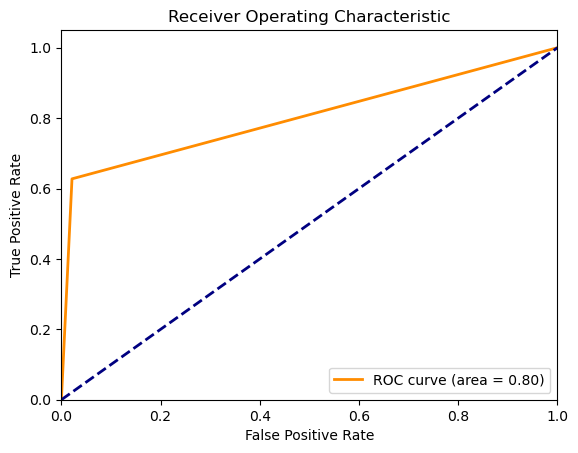

In [56]:
plt.figure()
plt.plot(fpr_ada, tpr_ada, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()